Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, RocCurveDisplay, roc_curve, auc
from matplotlib import pyplot as plt
import seaborn as sns

titanicdf = pd.read_csv("../../data/train_v1_fe.csv", index_col=0)
titanicdf.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'AgeClass', 'is_middleaged', 'is_old',
       'is_Male', 'is_Pclass_2', 'is_Pclass_3', 'emb_q', 'emb_s',
       'has_relatives', 'scld_Age', 'scld_Fare'],
      dtype='object')

In [2]:
y = titanicdf["Survived"]
X = titanicdf[['is_Male', 'is_Pclass_2', 'is_Pclass_3', 'emb_q', 'emb_s', 'has_relatives', 'scld_Age', 'scld_Fare']]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [4]:
m_lr = LogisticRegression()#class_weight="balanced")

In [5]:
m_lr.fit(X_train, y_train)

LogisticRegression()

Display Keys, coefficients and intecept of model

In [6]:
X_train.keys(), m_lr.coef_[0], m_lr.intercept_[0]

(Index(['is_Male', 'is_Pclass_2', 'is_Pclass_3', 'emb_q', 'emb_s',
        'has_relatives', 'scld_Age', 'scld_Fare'],
       dtype='object'),
 array([-2.45006632, -0.44194252, -1.72472988, -0.13446361, -0.60333457,
        -0.02941794, -1.3276559 ,  0.44592498]),
 2.922084695172682)

Visualization of model predictions /w probabilities

In [7]:
y_train_pred = m_lr.predict(X_train)
y_train_pred_prob = m_lr.predict_proba(X_train)

eval_tdata = pd.DataFrame()
eval_tdata['Survived?'] = y_train
eval_tdata['prediction'] = y_train_pred
eval_tdata['prob for surv'] = m_lr.predict_proba(X_train)[:,1]
eval_tdata['prob for drow'] = m_lr.predict_proba(X_train)[:,0]
eval_tdata.sample(10)

,Survived?,prediction,prob for surv,prob for drow
PassengerId,,,,
733,0,0,0.256022,0.743978
159,0,0,0.087704,0.912296
21,0,0,0.244616,0.755384
125,0,0,0.271435,0.728565
224,0,0,0.087651,0.912349
428,1,1,0.830540,0.169460
512,0,0,0.087661,0.912339
634,0,0,0.348689,0.651311
69,1,1,0.573193,0.426807


Accuracy Score

In [8]:
trn_scr = m_lr.score(X_train, y_train)
tst_scr = m_lr.score(X_test, y_test)
print(f"{round(trn_scr,3)*100:0.1f}% of survival-statuses were predicted correctly for train data")
print(f"{round(tst_scr,3)*100:0.1f}% of survival-statuses were predicted correctly for test data")

79.4% of survival-statuses were predicted correctly for train data
78.8% of survival-statuses were predicted correctly for test data


try 90% and 10% threshholds

In [9]:
new_thresh_eval90 = eval_tdata.copy()
new_thresh_eval10 = eval_tdata.copy()

In [10]:
new_thresh_eval90.loc[new_thresh_eval90["prob for surv"] >= 0.9, "prob for surv"] = 1
new_thresh_eval90.loc[new_thresh_eval90["prob for surv"] < 0.9, "prob for surv"] = 0

new_thresh_eval10.loc[new_thresh_eval10["prob for surv"] >= 0.1, "prob for surv"] = 1
new_thresh_eval10.loc[new_thresh_eval10["prob for surv"] < 0.1, "prob for surv"] = 0


#new_thresh_eval

In [11]:
corr_pred90 = (new_thresh_eval90["prob for surv"].astype(int) == new_thresh_eval90["Survived?"]).value_counts()

corr_pred10 = (new_thresh_eval10["prob for surv"].astype(int) == new_thresh_eval10["Survived?"]).value_counts()

th90 = round(corr_pred90[0] / corr_pred90.sum()*100,1)
th10 = round(corr_pred10[0] / corr_pred10.sum()*100,1)

print(f"With threshold at 90%, the percentage of correct predictions is: {th90}%")
print(f"With threshold at 10%, the percentage of correct predictions is: {th10}%")

With threshold at 90%, the percentage of correct predictions is: 65.7%
With threshold at 10%, the percentage of correct predictions is: 54.4%


Precision-, Recall- and F1-Score

In [12]:
ps = precision_score(y_train, y_train_pred)
rs = recall_score(y_train, y_train_pred)
fs = f1_score(y_train, y_train_pred)

In [13]:
print(f"Precision score = {round(ps*100,1)}%")
print(f"Recall score = {round(rs*100,1)}%")
print(f"F1 score = {round(fs*100,1)}%")

Precision score = 73.9%
Recall score = 69.8%
F1 score = 71.8%


Confusion Matrix

In [14]:
cm = confusion_matrix(y_train, y_train_pred)

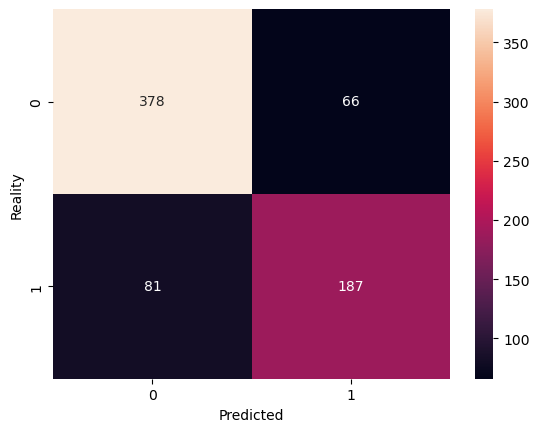

In [15]:
sns.heatmap(cm,
            annot=True,
            fmt = 'g'
            )
plt.xlabel('Predicted')
plt.ylabel('Reality')
plt.show()

ROCurve

In [16]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

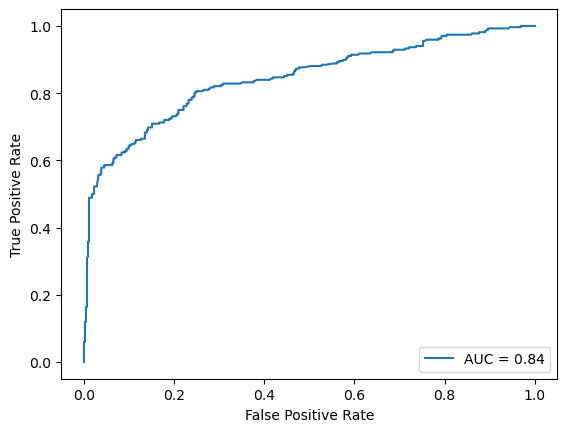

In [17]:
dp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
dp.plot()
plt.show()

Find optimal threshold

In [18]:
roc_params = pd.DataFrame()

roc_params["tpr"] = tpr
roc_params["fpr"] = fpr
roc_params["thresholds"] = thresholds

roc_params

,tpr,fpr,thresholds
0,0.000000,0.000000,1.942536
1,0.003731,0.000000,0.942536
2,0.026119,0.000000,0.930931
3,0.033582,0.000000,0.930151
4,0.059701,0.000000,0.918821
...,...,...,...
243,0.992537,0.941441,0.076644
244,0.996269,0.943694,0.076365
245,0.996269,0.968468,0.070693
246,1.000000,0.968468,0.070686


In [19]:
opti = np.argmax(tpr-fpr)

print(f"Optimal True-Positive-Rate: {tpr[opti]}")
print(f"Optimal False-Positive-Rate: {fpr[opti]}")
print(f"Optimal Threshold: {thresholds[opti]}")

Optimal True-Positive-Rate: 0.7089552238805971
Optimal False-Positive-Rate: 0.15090090090090091
Optimal Threshold: 0.49070893445651365
